## Code Documentation

This code performs bayesian analysis on the frequentist model results.

In [1]:
# Import the necessary libraries needed
import pandas as pd
import seaborn as sns
import numpy as np
import arviz as az
from scipy.special import expit
from utils.metrics import calculate_metrics, confidence_interval
from utils.Plots import predictions_with_uncertainty
from matplotlib import pyplot as plt
from sklearn.calibration import calibration_curve

In [2]:
training_set = pd.read_csv("datasets/training_set.csv", index_col=0)
validation_set = pd.read_csv("datasets/validation_set.csv", index_col=0)
test_set = pd.read_csv("datasets/test_set_preprocessed.csv", index_col = 0)

df_X_train = training_set.drop('label', axis=1)
y_train = training_set['label']
df_X_val = validation_set.drop('label', axis=1)
y_val = validation_set['label']
df_X_test = test_set.drop('label', axis=1)
y_test = test_set['label']

#### Frequentist bootstrapped results

In [3]:
#logistic = pd.read_csv("results/frequentist_results/Frequentist_logistic.csv", index_col=0)
#logistic = pd.read_csv("results/frequentist_results/Frequentist_lasso.csv", index_col=0)
logistic = pd.read_csv("results/frequentist_results/Frequentist_elasticnet.csv", index_col=0)

In [4]:
beta_values = logistic.loc[:,"beta.1":"beta.763"]
alpha_values = logistic.loc[:,"intercept"]

In [5]:
logistic_pred_train_dist = []
logistic_val_dist = []
logistic_test_dist = []
for ind in range(len(alpha_values)):
    lp_train = np.dot(df_X_train, beta_values.iloc[ind,]) + alpha_values[ind]
    lp_val = np.dot(df_X_val, beta_values.iloc[ind,]) + alpha_values[ind]
    lp_test = np.dot(df_X_test, beta_values.iloc[ind,]) + alpha_values[ind]
    prob_train = expit(lp_train)
    prob_val = expit(lp_val)
    prob_test = expit(lp_test)
    logistic_pred_train_dist.append(prob_train)
    logistic_val_dist.append(prob_val)
    logistic_test_dist.append(prob_test)
    
logistic_pred_train_dist = pd.DataFrame(logistic_pred_train_dist)
logistic_val_dist = pd.DataFrame(logistic_val_dist)
logistic_test_dist = pd.DataFrame(logistic_test_dist)

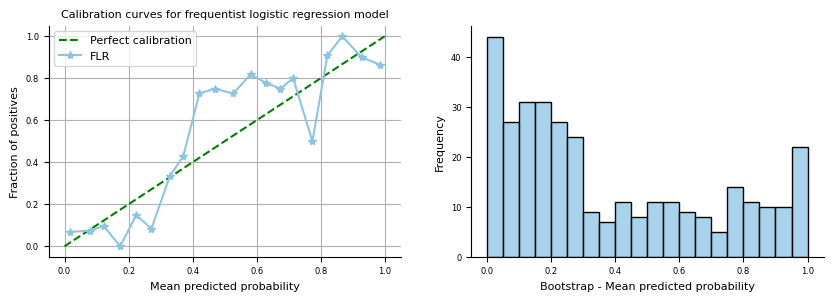

In [6]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, logistic_val_dist.mean(), n_bins=20)

plt.figure(figsize=(10, 3))

plt.subplot(1,2,1)
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfect calibration", color='green')
plt.plot(mean_predicted_value, fraction_of_positives, marker='*', label="FLR", color='#8cc5e3')
plt.xlabel("Mean predicted probability", fontsize=8)
plt.ylabel("Fraction of positives", fontsize=8)
plt.legend(fontsize=8)
plt.grid(True)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.title("Calibration curves for frequentist logistic regression model", fontsize=8)

plt.subplot(1,2,2)
sns.histplot(np.array(logistic_val_dist.mean()), color='#8cc5e3', fill=True, bins=20)
plt.xlabel("Bootstrap - Mean predicted probability", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.show()

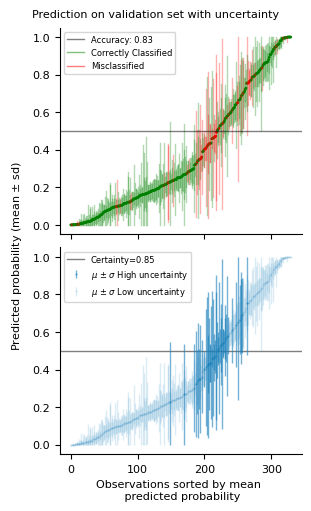

In [17]:
valid_uncertainty = predictions_with_uncertainty(logistic_val_dist, y_val, method = "FLR", t = 0.5,
                                          std_factor=1, 
                                          title = "Prediction on validation set with uncertainty",
                                          use_quantile=False)
#valid_uncertainty.savefig("plots/flesnet_val_uncertain.pdf", dpi = 2000, bbox_inches="tight")
valid_uncertainty.show()

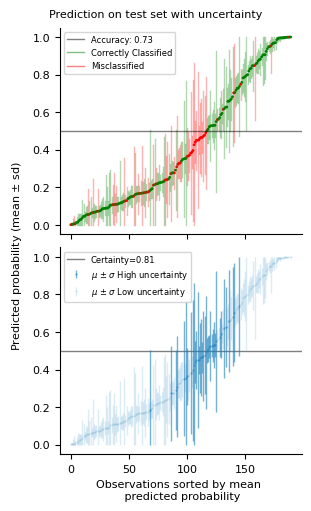

In [18]:
test_uncertainty = predictions_with_uncertainty(logistic_test_dist, y_test, method = "FLR", t = 0.5,
                                          std_factor=1, 
                                          title = "Prediction on test set with uncertainty",
                                          use_quantile=False)
#test_uncertainty.savefig("plots/flesnet_test_uncertain.pdf", dpi = 2000, bbox_inches="tight")
test_uncertainty.show()

In [9]:
# Define the samples length
n_samples = len(alpha_values)
df_train_pred = logistic_pred_train_dist.T
df_val_pred = logistic_val_dist.T
df_test_pred = logistic_test_dist.T

In [10]:
# Initialize lists to store metrics
metrics_train, metrics_val, metrics_test = [], [], []

for i in range(n_samples):
    # Calculate metrics for training data
    metrics_train.append(calculate_metrics(y_train, df_train_pred.iloc[:, i]))
    
    # Calculate metrics for validation data
    metrics_val.append(calculate_metrics(y_val, df_val_pred.iloc[:, i]))
    
    # Calculate metrics for testing data
    metrics_test.append(calculate_metrics(y_test, df_test_pred.iloc[:, i]))

# Convert lists to DataFrames
metrics_train_df = pd.DataFrame(metrics_train, columns=['sens', 'spec', 'auc', 'acc', 'f1', 'logloss', 'ppv', 'npv'])
metrics_val_df = pd.DataFrame(metrics_val, columns=['sens', 'spec', 'auc', 'acc', 'f1', 'logloss', 'ppv', 'npv'])
metrics_test_df = pd.DataFrame(metrics_test, columns=['sens', 'spec', 'auc', 'acc', 'f1', 'logloss', 'ppv', 'npv'])

In [11]:
dfs = []

# For each metric
for metric in ['sens', 'spec', 'auc', 'acc', 'f1', 'logloss', 'ppv', 'npv']:
    results = {}
    for dataset in ['train', 'val', 'test']:
        ci_lower, mean, ci_upper = confidence_interval(eval(f'metrics_{dataset}_df')[metric])
        results[f'{dataset} mean'] = mean
        results[f'{dataset} 95% CI'] = f'[{ci_lower}, {ci_upper}]'
    dfs.append(pd.DataFrame(results, index=[metric]))

# Concatenate the DataFrames
df_results = pd.concat(dfs)
df_results.index = [
    'Sensitivity', 'Specificity', 'AUC', 'Accuracy', 
    'F1 Score', 'Log Loss', 'PPV', 'NPV'
]
df_results.columns = [
    "training", "training 95% CI", "validation", "validation 95% CI", 
    "testing", "testing 95% CI"
]

# Display the results
df_results

,training,training 95% CI,validation,validation 95% CI,testing,testing 95% CI
Sensitivity,0.7969,"[0.7332, 0.8479]",0.7103,"[0.6423, 0.7805]",0.6086,"[0.5273, 0.6818]"
Specificity,0.9336,"[0.9175, 0.9466]",0.8822,"[0.8454, 0.913]",0.8992,"[0.8559, 0.9375]"
AUC,0.9312,"[0.9204, 0.9399]",0.8538,"[0.8155, 0.8852]",0.8054,"[0.7569, 0.8462]"
Accuracy,0.8824,"[0.8622, 0.9002]",0.8181,"[0.7818, 0.8515]",0.7310,"[0.6842, 0.7789]"
F1 Score,0.8351,"[0.8006, 0.8648]",0.7440,"[0.6921, 0.7959]",0.7231,"[0.6611, 0.7812]"
Log Loss,0.3612,"[0.3376, 0.3905]",0.6108,"[0.4969, 0.7356]",1.0086,"[0.7311, 1.3198]"
PPV,0.8779,"[0.8535, 0.8982]",0.7821,"[0.7265, 0.831]",0.8926,"[0.8519, 0.9296]"
NPV,0.8851,"[0.8552, 0.9112]",0.8370,"[0.8053, 0.872]",0.6264,"[0.5816, 0.6759]"


In [12]:
coefficients = logistic.loc[:,'beta.1':'beta.763']
coefficients["alpha"] = logistic.loc[:,"intercept"]
summary_coef = coefficients.describe(percentiles=[0.025,0.25, 0.5, 0.75, 0.975]).T

C:\Users\ravindranth\AppData\Local\Temp\ipykernel_19492\1381687546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefficients["alpha"] = logistic.loc[:,"intercept"]


In [13]:
extracted_features = []
beta_coefficients = []
for beta_name in summary_coef.index:
    lower = summary_coef.loc[beta_name, '2.5%']
    upper = summary_coef.loc[beta_name, '97.5%']
    if not (lower <= 0 <= upper) and beta_name != "alpha":
        extracted_features.append(int(beta_name.split('.')[1]))
        beta_coefficients.append(beta_name)

In [14]:
imp_features = df_X_train.columns[list(np.array(extracted_features) - 1)]
imp_features_coef = logistic.loc[:,beta_coefficients]
imp_features_coef.columns = imp_features

In [15]:
logistic_summary = logistic.loc[:,beta_coefficients].T
logistic_summary = logistic_summary.set_index(imp_features)

feat_dict = {}
for i, row in logistic_summary.iterrows():
    feat_dict[i] = list(np.array(logistic_summary.loc[i,:]))

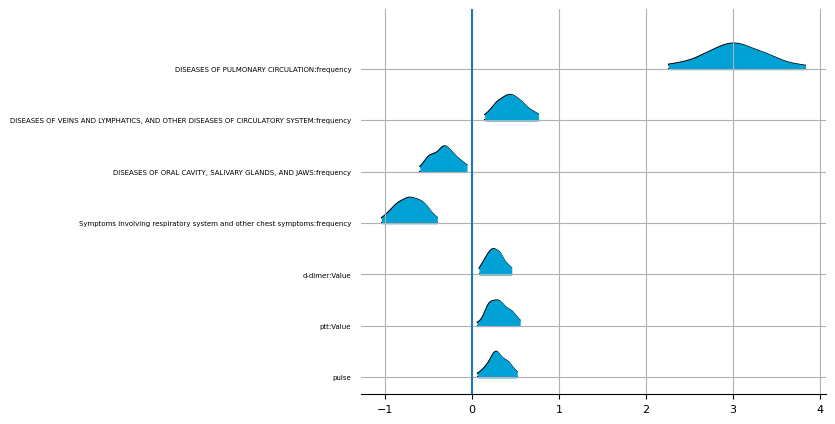

In [16]:
az.plot_forest(
        feat_dict,
        kind="ridgeplot",
        combined=True,
        colors="#00A1D5FF",
        figsize=(6, 5))
plt.grid()
plt.axvline(x=0)
plt.yticks(fontsize=5)
plt.xticks(fontsize=8)
plt.gca().spines["right"].set_color("none")
plt.gca().spines["top"].set_color("none")